In [32]:
from muselsl import *
import time
import numpy as np
import serial
from pylsl import StreamInlet, resolve_byprop
from calibrator import Calibrator
import utils 
from data_processor import *
from settings import *
from metrics import *
import buffer
from PsychoPy_Code.PsychoRun import run_psychopy
import matplotlib.pyplot as plt

In [2]:
# Search for active LSL streams

print('Looking for an EEG stream...')
streams = resolve_byprop('type', 'EEG', timeout=2)
if len(streams) == 0:
    raise RuntimeError('Can\'t find EEG stream.')

# Set active EEG stream to inlet and apply time correction

print("Start acquiring data")
inlet = StreamInlet(streams[0], max_chunklen=12)

# Get the stream info 
info = inlet.info()
fs = utils.get_fs(info)
buff = buffer.Buffer(inlet,fs )

Looking for an EEG stream...
Start acquiring data


[[  -65.4296875   -160.64453125  -232.421875   ...   387.20703125
   -721.6796875    204.1015625 ]
 [  290.52734375   205.56640625   160.64453125 ...   168.45703125
  -1000.          -456.54296875]
 [  157.2265625    103.02734375    74.70703125 ...   141.11328125
  -1000.          -474.12109375]
 [ -200.68359375  -200.1953125   -174.8046875  ...  -496.58203125
    992.1875      -813.96484375]
 [  -29.296875     -30.2734375     15.13671875 ...  -223.14453125
  -1000.          -193.84765625]]
(5, 256)
(5, 256)


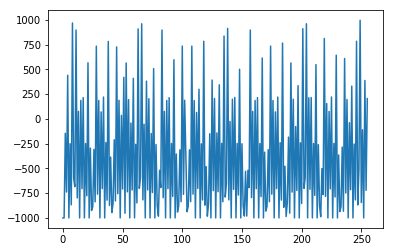

In [68]:

temp = buff.get_last_epoch()
print(temp.shape)
plt.plot(np.transpose(temp[0]))

In [69]:
"""
2. Obtain Threshold from PsychoPy 
"""

cal = Calibrator(inlet=inlet, info=info)

#run_psychopy(cal=cal)
#cal.train()

In [37]:
ch = description.child('channels').first_child()
ch_names = [ch.child_value('label')]

for i in range(5):
    ch = ch.next_sibling()
    ch_names.append(ch.child_value('label'))
ch_names 

['TP9', 'AF7', 'AF8', 'TP10', 'Right AUX', '']

In [42]:
_eeg_data, _timestamp = inlet.pull_chunk(
            timeout=1, max_samples=int(SHIFT_LENGTH * fs))

In [45]:
len(_eeg_data)


51

In [4]:
""" 
1. CONNECT TO EEG STREAM 
"""
threshold = 0.0223716588909309062
print("FINAL THRESH", threshold)

"""
3. Record data and wave hand if metric is above threshold.  

"""

print('Press Ctrl-C in the console to break the while loop.')

#arduinoData = serial.Serial('com3',9600)
time.sleep(1)
try:
    
    dp = DataProcessor(fs=fs)
    for i in [1,2]:
    #while True:
        """ 3.1 ACQUIRE DATA """

        utils.aquire_and_append_metrics(inlet, fs,dp)
        
        #get most recent slice
        data_slice = dp.get_recent_slice()
            
        # Classify against
        # Y =(data_slice) Model Weights + bias
        #cal.predict
        # Y should be a 
        


except KeyboardInterrupt:
    print('Closing!')

#arduinoData.close()

FINAL THRESH 0.022371658890930905
Press Ctrl-C in the console to break the while loop.
data buffer: [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]] shape (1280, 1)
new data: [[  274.4140625 ]
 [-1000.        ]
 [ -618.1640625 ]
 [ -950.68359375]
 [  484.375     ]
 [ -986.328125  ]
 [-1000.        ]
 [  252.9296875 ]
 [  981.93359375]
 [ -540.52734375]
 [-1000.        ]
 [ -175.78125   ]
 [ -817.87109375]
 [  156.73828125]
 [-1000.        ]
 [ -313.4765625 ]
 [ -821.77734375]
 [  279.78515625]
 [-1000.        ]
 [ -756.8359375 ]
 [  892.578125  ]
 [  598.6328125 ]
 [ -932.6171875 ]
 [-1000.        ]
 [  119.62890625]
 [ -919.43359375]
 [ -357.421875  ]
 [-1000.        ]
 [ -182.12890625]
 [ -810.05859375]
 [  249.51171875]
 [-1000.        ]
 [ -422.8515625 ]
 [ -854.4921875 ]
 [  283.69140625]
 [-1000.        ]
 [ -878.90625   ]
 [  719.23828125]
 [  706.0546875 ]
 [ -874.51171875]
 [-1000.        ]
 [   14.6484375 ]
 [ -836.42578125]
 [ -166.015625  ]
 [-1000.        ]
 [ -187.5       ]
 [ -

NameError: name 'Band' is not defined

In [64]:
arduinoData.close()